<div style="text-align:center; font-size:200%; font-weight:bold;">
    Face Recognition Machine Learning Project
</div>



**Contributos:**

- Paweł Strzałecki
- Jakub Węgrzynek
- Aleksander Mackiewicz-Kubiak
- Natalia Szczepkowska

**Goal of the project:** The goal of the following project is to successfully build Machine Learning models capable of correctly recongizing human faces on photos. The chosen models are: SVC (Support Vector Classifier), CNN (Convolutional Neural Network) and (Paweł).

**Our approach:** To achieve the project's main goal, we used two types of photographs: those with human faces and those without. Here's what we did step by step:

1. Photograph Preparation:

- With Faces: Cropped to show only the person's face.
- Without Faces: Cropped to the same size as the face crops multiple times (to artificially enlarge and modify the set).

2. Dataset Creation: Mixed the cropped face and non-face images to create training and test sets and applied HOG feature descriptor

3. Model Training: Trained models using these sets.

4. Model Testing: Used sliding windows on test images. These windows move across the image, and the model predicts if each window contains a face. If an image has at least 10 windows where a face is detected, we classify the image as containing a human face.


Crucial step of the whole process is applying **HOG feature descriptor**: 


The Histogram of Oriented Gradients (HOG) is a feature descriptor used in computer vision and image processing for object detection. The idea behind HOG is that the local object appearance and shape within an image can be described by the distribution of intensity gradients or edge directions. This feature descriptor is a vector (or sometimes a multi-dimensional array) that encodes the distribution of gradient orientations in localized regions of an image. This vector is formed by concatenating the histograms of gradients computed over small, overlapping regions.

### Imports

In [30]:
import numpy as np
from skimage import color, feature, transform, io
from skimage.transform import rotate, rescale

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.image import PatchExtractor
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from itertools import chain
import os
import warnings
import random
import joblib

from skimage.feature import local_binary_pattern
from sklearn.metrics import accuracy_score
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from tensorflow import image

warnings.simplefilter(action='ignore', category=FutureWarning)

### Functions

In [3]:
# Function to ensure all images are grayscale
def ensure_grayscale(image):
    if image.ndim == 2:  # Image is already grayscale
        return image
    elif image.ndim == 3 and image.shape[2] == 3:  # Image is RGB
        return color.rgb2gray(image)
    else:
        raise ValueError("Unsupported image format")


# function to crop multiple different sections from images without faces.
def extract_patches(img, N, scale=1.0, patch_size=(125, 94)):
    # Calculate the size of the extracted patches
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Ensure the extracted patch size is valid
    if extracted_patch_size[0] <= 0 or extracted_patch_size[1] <= 0:
        raise ValueError(f"Invalid patch size {extracted_patch_size} for scale {scale}")

    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])

    # Resize patches to the original patch size if scaling is applied
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])

    return patches


# Function to load and preprocess images
def load_images(directory_path, file_list):
    images = []
    for file in file_list:
        try:
            image = io.imread(os.path.join(directory_path, file))
            image = ensure_grayscale(image)
            images.append(image)
        except (OSError, ValueError):
            pass
    return images


# function to show sample images
def show_sample_images(dataset):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9))
    for i, axi in enumerate(ax.flat):
        axi.imshow(dataset[i], cmap='gray')
        axi.axis('off')


# function to perform sliding windows 
def sliding_window(img, patch_size=(125, 94), istep=10, jstep=10, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch


# function to classify image using hog-svm model
def predict_hog_svm(test_image, model):
    indices, patches = zip(*sliding_window(test_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    labels = model.predict(patches_hog)

    if labels.sum() < 4:
        return False
    else:
        return True


def test_model_svc(test_images, test_labels, model):
    predicts = []
    for idx, image in enumerate(test_images):
        try:
            predicts.append(predict_hog_svm(image, model))

            # Print progress
            if idx % 100 == 0:
                print(f'Processed {idx} images')

        except ValueError:
            print(f'Skipping image {idx}')

    # Calculate overall accuracy
    correct_predictions = sum([1 for true, pred in zip(test_labels, predicts) if true == pred])
    accuracy = round(correct_predictions / len(test_labels), 4)

    # Calculate correct predictions for ones and zeros
    ones_correct = sum([1 for true, pred in zip(test_labels, predicts) if true == 1 and pred == 1])
    zeros_correct = sum([1 for true, pred in zip(test_labels, predicts) if true == 0 and pred == 0])

    total_ones = np.sum(test_labels == 1)
    total_zeros = np.sum(test_labels == 0)

    ones_accuracy = round(ones_correct / total_ones, 4)
    zeros_accuracy = round(zeros_correct / total_zeros, 4)

    return accuracy, ones_accuracy, zeros_accuracy


# Function to predict the label of an image based on sliding windows
def predict_cnn(model, image, threshold=4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ws1, ws2 = face_cropped_train[0].shape

    model.eval()
    model.to(device)

    # Initialize count of positive predictions
    positive_count = 0

    # Perform sliding window over the image to get patches
    for (i, j), patch in sliding_window(image, patch_size=(ws1, ws2)):
        patch = np.array(patch, dtype=np.float32)

        # Convert patch to PyTorch tensor and add batch dimension
        patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Predict on patch
        with torch.no_grad():
            output = model(patch_tensor)
            pred = torch.round(output.squeeze())
            positive_count += pred.item()

    # If at least 'threshold' patches are predicted as 1, classify the image as 1
    return 1 if positive_count > threshold else 0


def rotate_image(image, angle):
    return rotate(image, angle, resize=False)


def resize_image(image, scale, target_shape):
    resized_image = rescale(image, scale, anti_aliasing=True)
    pad_height = (target_shape[0] - resized_image.shape[0]) // 2
    pad_width = (target_shape[1] - resized_image.shape[1]) // 2
    # Ensure padding matches the target shape
    # noinspection PyTypeChecker
    padded_image = np.pad(resized_image,
                          ((pad_height, target_shape[0] - resized_image.shape[0] - pad_height),
                           (pad_width, target_shape[1] - resized_image.shape[1] - pad_width)),
                          'constant', constant_values=0)
    return padded_image


def create_zero_padding(image, levels=1):
    for _ in range(levels):
        zeros_vertical = np.asarray([0] * image.shape[0])[:, np.newaxis]
        stacked_horizontally = np.hstack((zeros_vertical, image, zeros_vertical))

        zeros_horizontal = np.asarray([0] * stacked_horizontally.shape[1])[np.newaxis, :]
        stacked_vertically = np.vstack((zeros_horizontal, stacked_horizontally, zeros_horizontal))
        image = stacked_vertically

    return image


def remove_zero_padding(image, levels=1):
    return image[levels:-levels, levels:-levels]


def lbp_sign(center, neighbor):
    if neighbor >= center:
        return 1
    elif neighbor < center:
        return 0


def convert_to_decimal(center, neighbors):
    summation = 0
    for i in range(len(neighbors)):
        summation += lbp_sign(center, np.flip(neighbors)[i]) * 2 ** i

    return summation


def lbp(image, P=8, R=1, roll_val=-3, levels=1, progress=False):
    if progress == True:
        from tqdm import tqdm
    elif progress == False:
        def tqdm(x):
            return x

    image = create_zero_padding(image)
    processed_image = image.copy()

    sampling_points_x = np.roll(np.asarray([-np.round(R * np.sin((2 * np.pi * i) / P), 3) for i in range(P)]), roll_val)
    sampling_points_y = np.roll(np.asarray([np.round(R * np.cos((2 * np.pi * i) / P), 3) for i in range(P)]), roll_val)

    height = image.shape[0]
    width = image.shape[1]

    for i in tqdm(range(levels, height - levels)):
        for j in range(levels, width - levels):

            center = image[i, j]
            neighbor_values = []

            for x, y in zip(sampling_points_x, sampling_points_y):
                neighbor_values.append(image[round(i + y), round(j + x)])

            new_center = convert_to_decimal(center, neighbor_values)
            processed_image[i, j] = new_center

    processed_image = remove_zero_padding(processed_image)

    return processed_image


def extract_blocks(image, window_size=(8, 8), step_size=8):
    h, w = image.shape[:2]
    window_h, window_w = window_size

    windows = []

    for y in range(0, h - window_h + 1, step_size):
        for x in range(0, w - window_w + 1, step_size):
            window = image[y:y + window_h, x:x + window_w]
            windows.append(window)

    return windows


def extract_feature_vector(image):
    lbp_image = lbp(image)
    blocks = extract_blocks(lbp_image)

    feature_vector = [np.histogram(block, bins=256, range=(0, 255), density=True)[0] for block in blocks]

    return np.concatenate(feature_vector)


def get_ROIs(image):
    image = image.astype(np.float32)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ROI_xywh = ss.process()
    return ROI_xywh


def xywh_to_points(ROIs_xywh):
    ROI_coords = []
    for ROI in ROIs_xywh:
        x1 = ROI[0]
        y1 = ROI[1]
        x2 = x1 + ROI[2]
        y2 = y1 + ROI[3]
        ROI_coords.append([x1, y1, x2, y2])
    return ROI_coords


def crop_ROIs(image, ROIs):
    resized_ROIs = []

    image = color.rgb2gray(image)
    image = Image.fromarray(image)

    for bbox in ROIs:
        roi = image.crop(bbox)
        roi = np.asarray(roi)
        roi = transform.resize(roi, (125, 94))
        resized_ROIs.append(roi)

    return np.array(resized_ROIs)


def plot_predictions(image, bboxes):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
    ax1.imshow(image, cmap='gray')

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox

        width = abs(x1 - x2)
        height = abs(y1 - y2)
        xmin = min([x1, x2])
        ymin = min([y1, y2])

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

    ax1.axis('off')

    plt.show()

### Loading data

#### Loading faces

In [4]:
# Load full and cropped images with faces
lfw_people_full = fetch_lfw_people(resize=None, slice_=(slice(0, 250), slice(0, 250)))  # full size images
lfw_people_cropped = fetch_lfw_people(resize=None)  # cropped images

# Extract train/test full/cropped images +/- 80% ratio
split_point = 11000
face_full_test = lfw_people_full.images[split_point:]
face_cropped_train = lfw_people_cropped.images[:split_point]

print(face_full_test.shape)
print(face_cropped_train.shape)

(2233, 250, 250)
(11000, 125, 94)


#### Face images augmentation

In [5]:
# Load face_cropped_train as a NumPy array (assuming it is already a list of images)
face_cropped_train = np.array(face_cropped_train)

# Determine the number of images to transform
num_images = len(face_cropped_train)
num_to_transform = int(0.1 * num_images)

# Shuffle the indices of the images
indices = list(range(num_images))
random.shuffle(indices)

# Select indices for transformations
indices_rotate_right = indices[:num_to_transform]
indices_rotate_left = indices[num_to_transform:2 * num_to_transform]
indices_resize = indices[2 * num_to_transform:3 * num_to_transform]

# Create a list to store transformed images
transformed_images = []

# Apply transformations
for idx in indices_rotate_right:
    transformed_images.append(rotate_image(face_cropped_train[idx], 25))

for idx in indices_rotate_left:
    transformed_images.append(rotate_image(face_cropped_train[idx], -25))

target_shape = face_cropped_train[0].shape

for idx in indices_resize:
    resized_image = resize_image(face_cropped_train[idx], 0.7, target_shape)
    transformed_images.append(resized_image)

# Convert the list of transformed images to a NumPy array
transformed_images = np.array(transformed_images)

# Append the transformed images to the original array
face_cropped_train = np.append(face_cropped_train, transformed_images, axis=0)


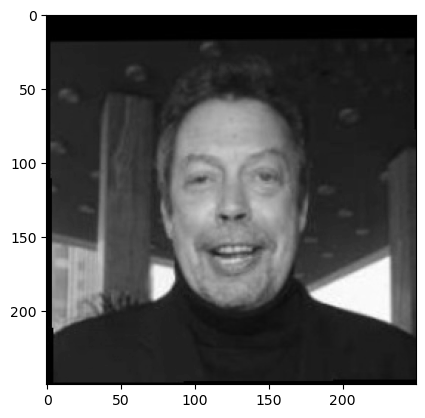

In [6]:
plt.imshow(lfw_people_full['images'][0], cmap='gray');

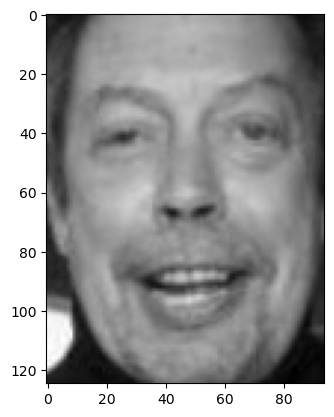

In [7]:
plt.imshow(lfw_people_cropped['images'][0], cmap='gray');

#### Loading images with no faces

In [6]:
# Directory paths containing the images
noface_test_directory_path = '2k_noface_test/'
noface_train_directory_path = '6k_noface_train/'

# List all image files in the directory
noface_test_files = os.listdir(noface_test_directory_path)
noface_train_files = os.listdir(noface_train_directory_path)

# Load and preprocess the images
noface_full_train = load_images(noface_train_directory_path, noface_train_files)
noface_full_test = load_images(noface_test_directory_path, noface_test_files)

# Collect negative patches from all images and scales
noface_cropped_train = []
for im in noface_full_train:
    for scale in [0.5, 1.0]:
        try:
            patches = extract_patches(im, 4, scale)
            noface_cropped_train.append(patches)
        except ValueError as e:
            pass

# Stack the patches into a single array
noface_cropped_train = np.vstack(noface_cropped_train)

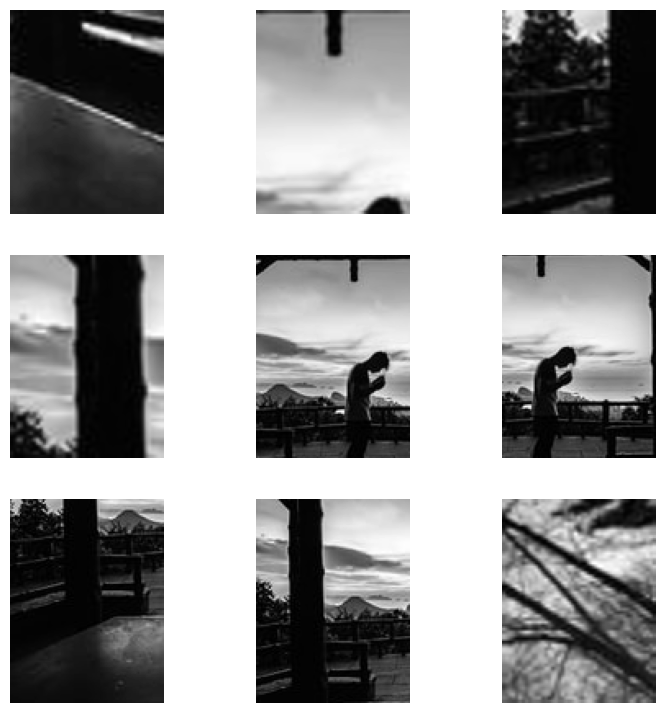

In [9]:
# Show sample cropped images without faces
show_sample_images(noface_cropped_train)

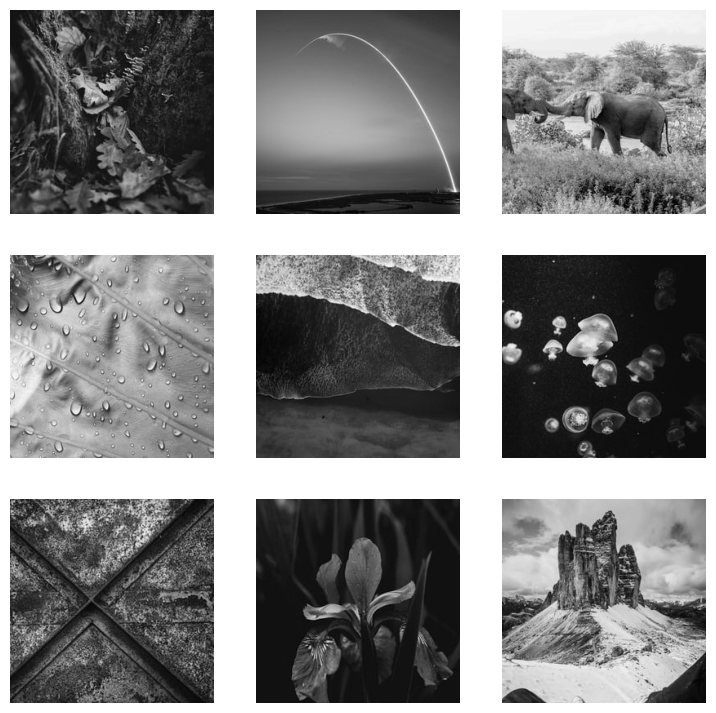

In [10]:
# Show sample full images without faces
show_sample_images(noface_full_test)

#### Creating final datasets for SVM

In [11]:
# Mix the images with and without faces and apply HOG feature descriptor
X_train = np.array([feature.hog(img) for img in chain(face_cropped_train, noface_cropped_train)])
y_train = np.zeros(X_train.shape[0])
y_train[:face_cropped_train.shape[0]] = 1

print(X_train.shape)
print(y_train.shape)

(62196, 9477)
(62196,)


In [21]:
X_test = np.array([img for img in chain(face_full_test[500:1000], noface_full_test[500:1000])])
y_test = np.zeros(X_test.shape[0])
y_test[:500] = 1

print(X_test.shape)
print(y_test.shape)

(1000, 250, 250)
(1000,)


## SVM

#### Grid Search

In [13]:
# Perform Grid Search to find the best regularization parameter C
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.974965918570082

In [14]:
grid.best_params_

{'C': 4.0}

#### Fitting model

In [15]:
# Fit the model with the best found C to the train data
model_svc = grid.best_estimator_
model_svc.fit(X_train, y_train)

LinearSVC(C=4.0)

#### Saving / loading model

In [19]:
# Save the model
joblib.dump(model_svc, "model_svc.pkl")

# Load the model
# model_svc = joblib.load("linear_svc.pkl")

['model_svc.pkl']

#### Statistics

In [ ]:
accuracy, correct_faces, correct_nofaces = test_model_svc(X_test, y_test, model_svc)


In [22]:
print(f'Accuracy: {accuracy * 100}%')
print(f'Face accuracy: {correct_faces * 100}%')
print(f'No face accuracy: {correct_nofaces * 100}%')

Accuracy: 98.2%
Face accuracy: 99.4%
No face accuracy: 97.0%


#### Show some images with predictions

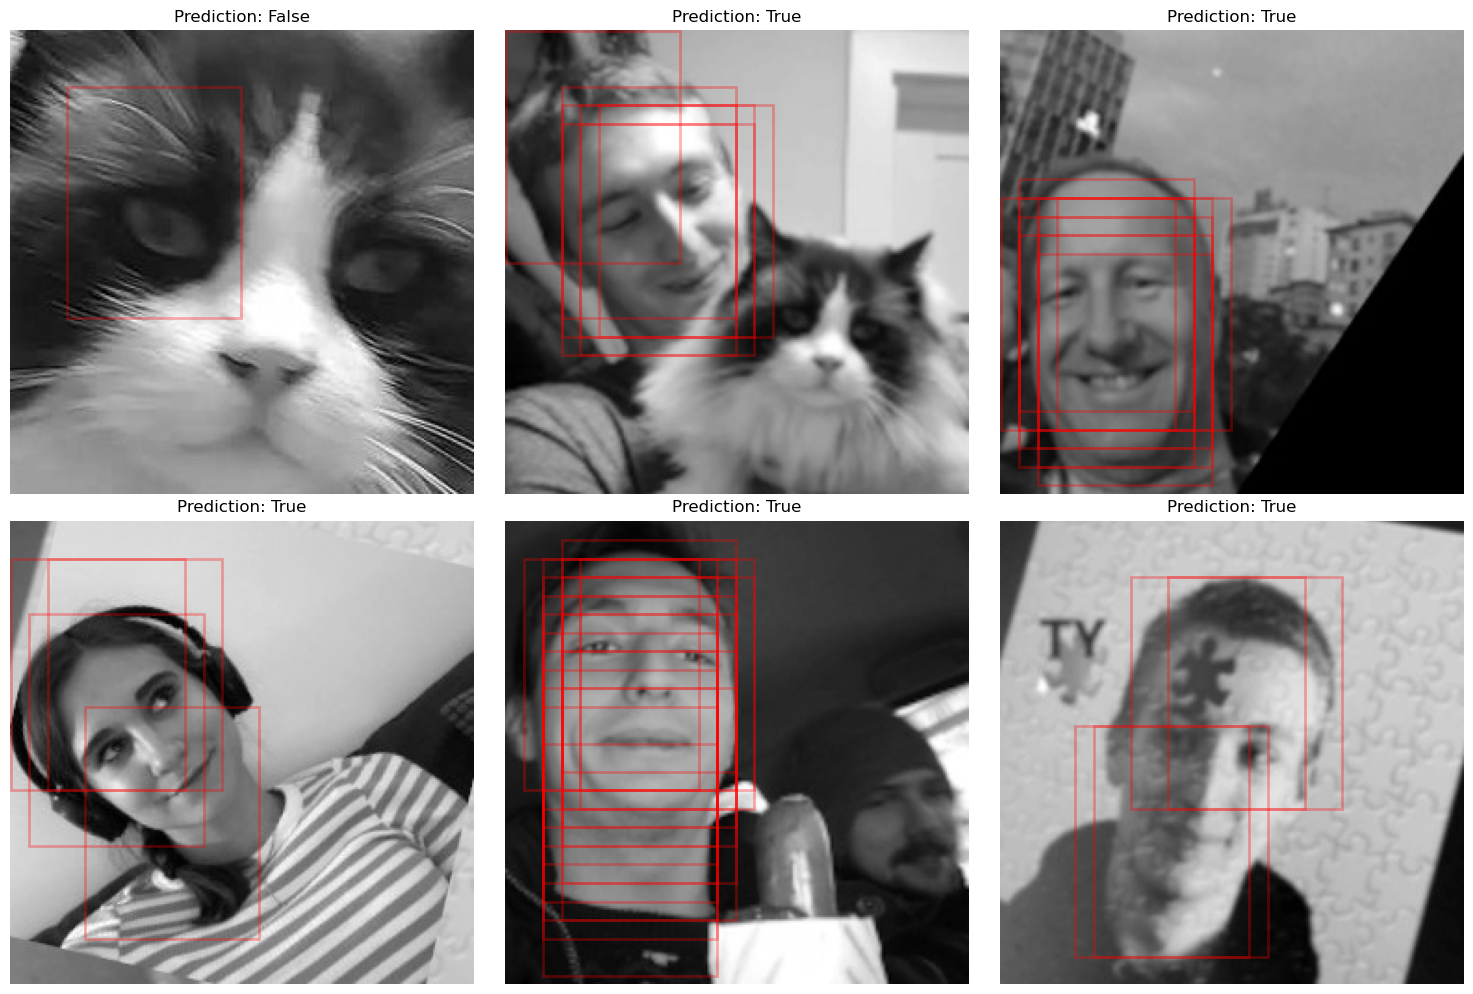

In [35]:
my_images = ['my_imgs/B.jpg', 'my_imgs/K.jpg', 'my_imgs/M.jpg',
             'my_imgs/N.jpg', 'my_imgs/P.jpg', 'my_imgs/T.jpg']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, image_name in enumerate(my_images):
    image = io.imread(image_name)
    test_image = color.rgb2gray(image)

    indices, patches = zip(*sliding_window(test_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    labels = model_svc.predict(patches_hog)

    prediction = predict_hog_svm(test_image, model_svc)

    ax = axes[idx]
    ax.imshow(test_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Prediction: {prediction}')

    Ni, Nj = 125, 94
    indices = np.array(indices)

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

plt.tight_layout()
plt.show()

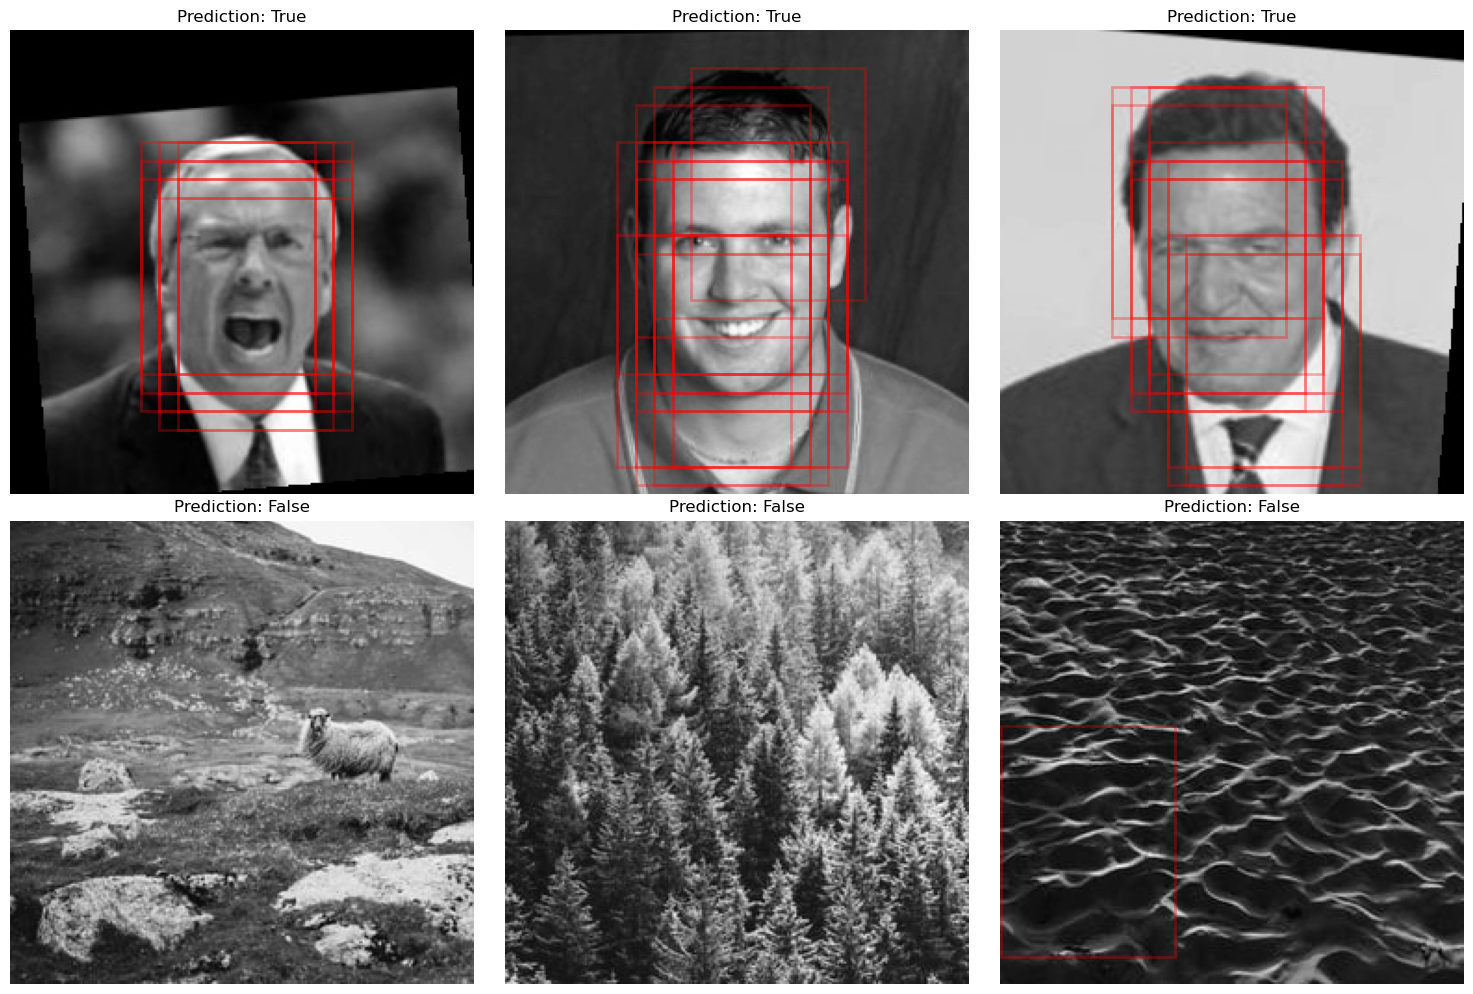

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, test_image in enumerate(X_test[497:503]):

    indices, patches = zip(*sliding_window(test_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    labels = model_svc.predict(patches_hog)

    prediction = predict_hog_svm(test_image, model_svc)

    ax = axes[idx]
    ax.imshow(test_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Prediction: {prediction}')

    Ni, Nj = 125, 94
    indices = np.array(indices)

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

plt.tight_layout()
plt.show()

# CNN

#### Creating datasets

In [23]:
X_train = np.array([img for img in chain(face_cropped_train, noface_cropped_train)])
y_train = np.zeros(X_train.shape[0])
y_train[:face_cropped_train.shape[0]] = 1

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(X_train.size())
print(y_train.size())

torch.Size([62196, 125, 94])
torch.Size([62196])


In [43]:
X_test = np.array([img for img in chain(face_full_test[500:1000], noface_full_test[500:1000])])
y_test = np.zeros(X_test.shape[0])
y_test[:500] = 1

print(X_test.shape)
print(y_test.shape)

(1000, 250, 250)
(1000,)


#### Building CNN

In [44]:
class FaceDetectionCNN(nn.Module):
    def __init__(self):
        super(FaceDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Calculate the size of the feature maps after the final pooling layer
        # Assuming input size is (1, 125, 94)
        self.fc1 = nn.Linear(128 * 15 * 11, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Output layer for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)  # Flatten the tensor except for the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid activation to the output

        return x

In [8]:
state_dict = torch.load('model_cnn.pth')

In [9]:
# Model instantiation
model_cnn = FaceDetectionCNN()

model_cnn.load_state_dict(state_dict)
# Print the model architecture
print(model_cnn)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

FaceDetectionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=21120, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


#### Training network

In [43]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model_cnn = model_cnn.to(device)

num_epochs = 7
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0.0

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        # Move the batches to the GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Ensure batch_x has the correct shape [batch_size, 1, H, W]
        batch_x = batch_x.unsqueeze(1)  # Add the channel dimension

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_cnn(batch_x)
        outputs = outputs.squeeze()  # Remove singleton dimension if present

        # Apply sigmoid to outputs if not already applied in the model
        # outputs = torch.sigmoid(outputs)

        # Ensure batch_y is of type float
        batch_y = batch_y.float()

        # Calculate loss
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(X_train):.4f}')


Epoch [1/7], Loss: 0.0013
Epoch [2/7], Loss: 0.0004
Epoch [3/7], Loss: 0.0003
Epoch [4/7], Loss: 0.0002
Epoch [5/7], Loss: 0.0002
Epoch [6/7], Loss: 0.0001
Epoch [7/7], Loss: 0.0001


In [44]:
torch.save(model_cnn.state_dict(), 'model_cnn.pth')

#### Testing

In [45]:
image_predictions = []

# Loop through each test image and predict
for image in X_test:
    image_label = predict_cnn(model_cnn, image)
    image_predictions.append(image_label)

# Convert image predictions to numpy array
image_predictions = np.array(image_predictions)

# Calculate accuracies
accuracy_no_face = round(100 * (image_predictions[500:] == 0).sum() / 500, 4)
accuracy_face = round(100 * (image_predictions[:500] == 1).sum() / 500, 4)
accuracy_total = round(100 * (image_predictions == y_test).sum() / 1000, 4)

print(f'Accuracy no face images: {accuracy_no_face}%')
print(f'Accuracy face images: {accuracy_face}%')
print(f'Accuracy whole dataset: {accuracy_total}%')


Accuracy no face images: 100.0%
Accuracy face images: 95.8%
Accuracy whole dataset: 97.9%


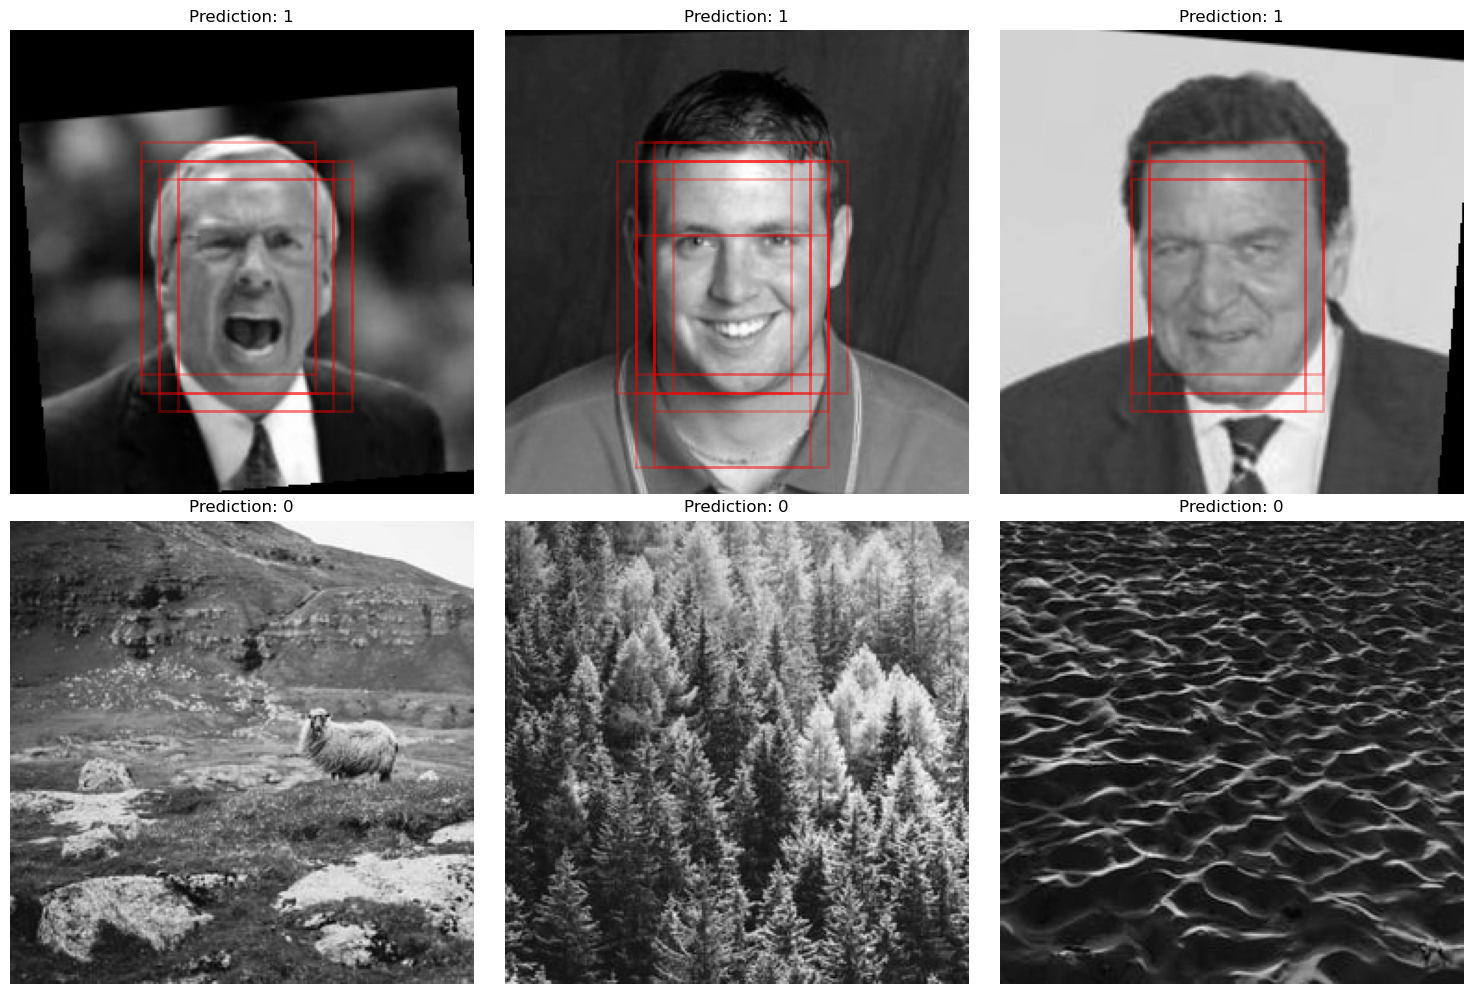

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, test_image in enumerate(X_test[497:503]):

    indices, patches = zip(*sliding_window(test_image))

    patches = np.array(patches, dtype=np.float32)

    patch_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1).to(device)

    # Predict on patch
    with torch.no_grad():
        output = model_cnn(patch_tensor)
        labels = torch.round(output.squeeze())

    prediction = predict_cnn(model_cnn, test_image)

    ax = axes[idx]
    ax.imshow(test_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Prediction: {prediction}')

    Ni, Nj = 125, 94
    indices = np.array(indices)

    labels = labels.cpu().numpy()

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

plt.tight_layout()
plt.show()

# LBP

#### Create dataset for LBP

In [7]:
X_face = face_cropped_train[:3333]
X_noface = noface_cropped_train[:3333]

X = np.concatenate((X_face, X_noface))
Y = np.array([1] * len(X_face) + [0] * len(X_noface))

In [8]:
X.shape, Y.shape

((6666, 125, 94), (6666,))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=42, stratify=Y)

In [10]:
(X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape)

(((4666, 125, 94), (4666,)), ((2000, 125, 94), (2000,)))

In [11]:
np.count_nonzero(Y_train), np.count_nonzero(Y_test)

(2333, 1000)

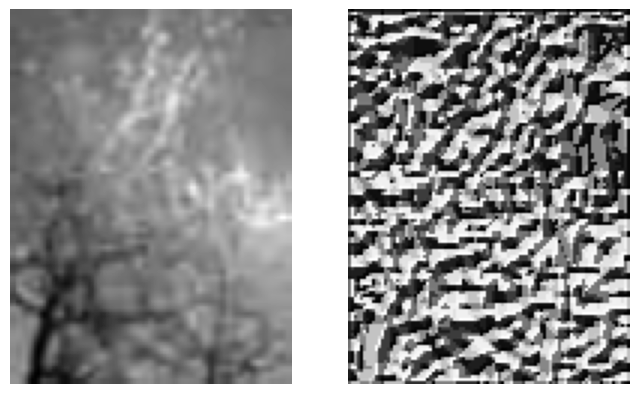

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

ax1.imshow(X_train[0], cmap='gray')
ax2.imshow(lbp(X_train[0]), cmap='gray')

ax1.axis('off')
ax2.axis('off')

plt.show()

#### PCA

In [13]:
faces_pca = PCA(n_components=0.9)
faces_pca.fit(X_face.reshape(3333, 125 * 94))

PCA(n_components=0.9)

In [14]:
components = faces_pca.transform([X_face[0].flatten()])
projected = faces_pca.inverse_transform(components)

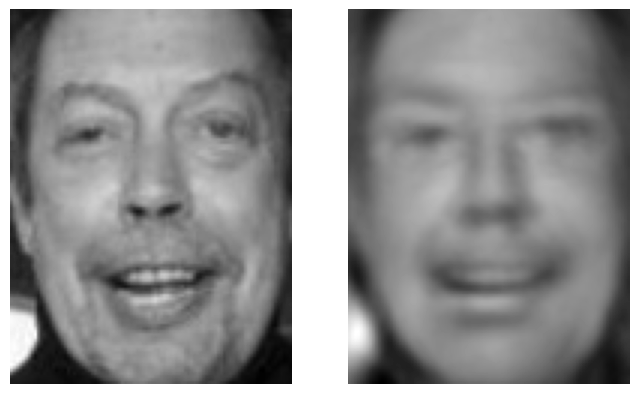

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

ax1.imshow(X_face[0], cmap='gray')
ax2.imshow(projected.reshape(125, 94), cmap='gray')

ax1.axis('off')
ax2.axis('off')

plt.show()

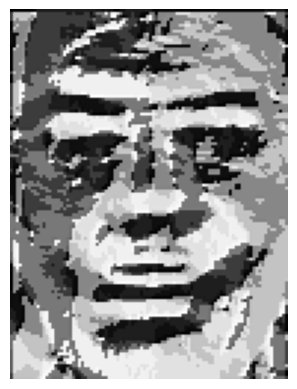

In [16]:
plt.imshow(lbp(projected.reshape(125, 94)), cmap='gray')
plt.axis('off')
plt.show()

#### Training model

In [17]:
components = faces_pca.transform(X_train.reshape(X_train.shape[0], 125 * 94))
projected = np.array(faces_pca.inverse_transform(components).reshape(X_train.shape[0], 125, 94))

In [18]:
X_train_pca = [extract_feature_vector(img) for img in projected]

In [19]:
KNN = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
KNN.fit(X_train_pca, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [20]:
test_components = faces_pca.transform(X_test.reshape(X_test.shape[0], 125 * 94))
test_projected = np.array(faces_pca.inverse_transform(test_components).reshape(X_test.shape[0], 125, 94))

In [21]:
X_test_pca = [extract_feature_vector(img) for img in test_projected]

In [22]:
accuracy_score(y_true=Y_test,
               y_pred=KNN.predict(X_test_pca))

0.8825

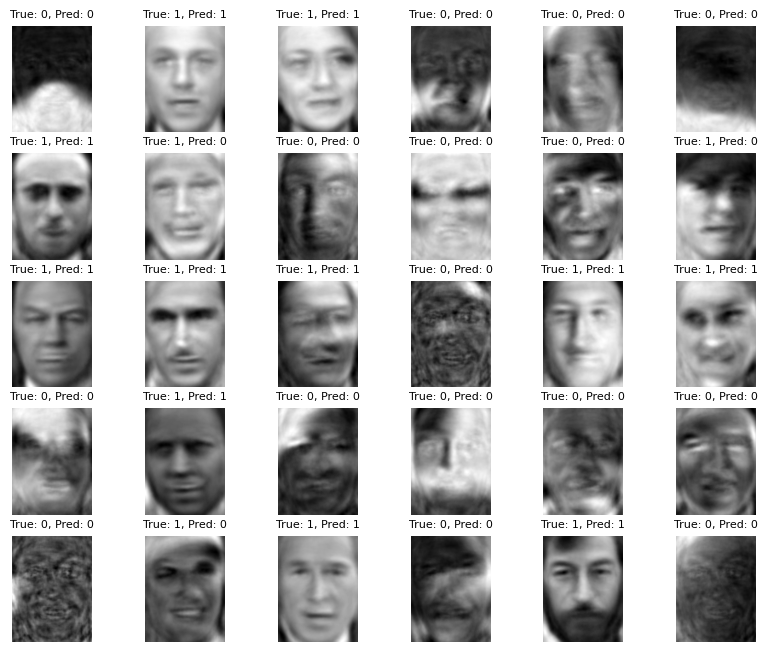

In [23]:
fig, ax = plt.subplots(5, 6, figsize=(10, 8))
for i, axi in enumerate(ax.flat):
    img = X_test[10 * i]
    img_pca = faces_pca.inverse_transform(faces_pca.transform([img.flatten()])).reshape(125, 94)
    feature_vector = extract_feature_vector(img_pca)
    y_true = Y_test[10 * i]
    y_pred = KNN.predict([feature_vector])[0]

    axi.imshow(img_pca, cmap='gray')
    axi.axis('off')
    axi.set_title(f'True: {y_true}, Pred: {y_pred}', fontsize=8)

#### Testing model

In [24]:
image_test = lfw_people_full.images[0]
image_test = color.gray2rgb(image_test)

ROIs_xywh = get_ROIs(image_test)
ROIs_coords = xywh_to_points(ROIs_xywh)

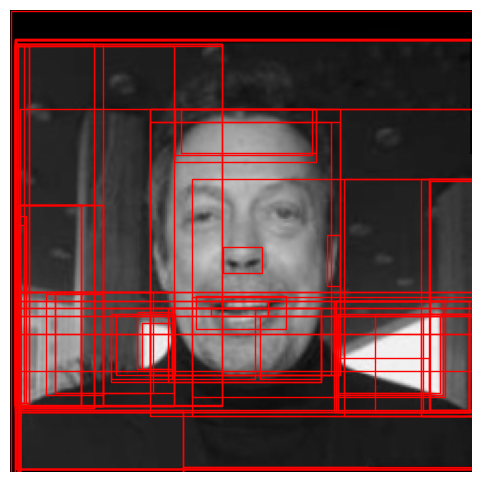

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(image_test)

for x, y, w, h in ROIs_xywh:
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.axis('off')

plt.show()

In [26]:
ROIs = crop_ROIs(image_test, ROIs_coords)

In [27]:
ROIs.shape

(85, 125, 94)

In [28]:
ROIs_components = faces_pca.transform(ROIs.reshape(ROIs.shape[0], 125 * 94))
ROIs_projected = np.array(faces_pca.inverse_transform(ROIs_components).reshape(ROIs.shape[0], 125, 94))

In [29]:
ROI_features_vectors = [extract_feature_vector(img) for img in ROIs_projected]

In [32]:
preds = KNN.predict(ROI_features_vectors)
np.count_nonzero(preds)

3

In [33]:
boxes = []
scores = []

for i in range(len(preds)):
    acc = preds[i]
    if acc == 1:
        boxes.append(ROIs_coords[i])
        scores.append(acc)

Number of faces: 1


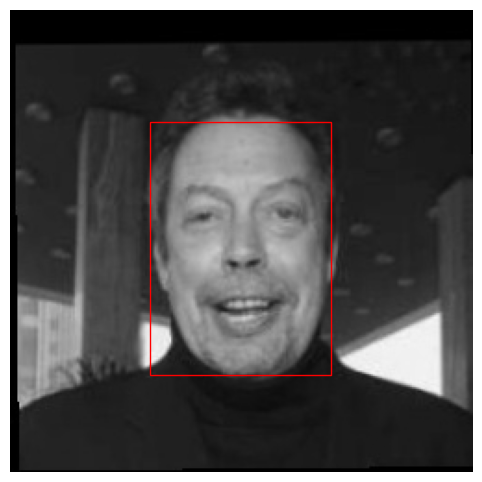

In [34]:
if len(boxes) != 0:
    NMS = image.non_max_suppression(boxes=boxes, scores=scores, max_output_size=len(boxes), iou_threshold=0.1)
    selected_bboxes = [boxes[idx] for idx in NMS]
    print('Number of faces:', len(selected_bboxes))
    plot_predictions(image_test, selected_bboxes)
else:
    print('There is no face in image')

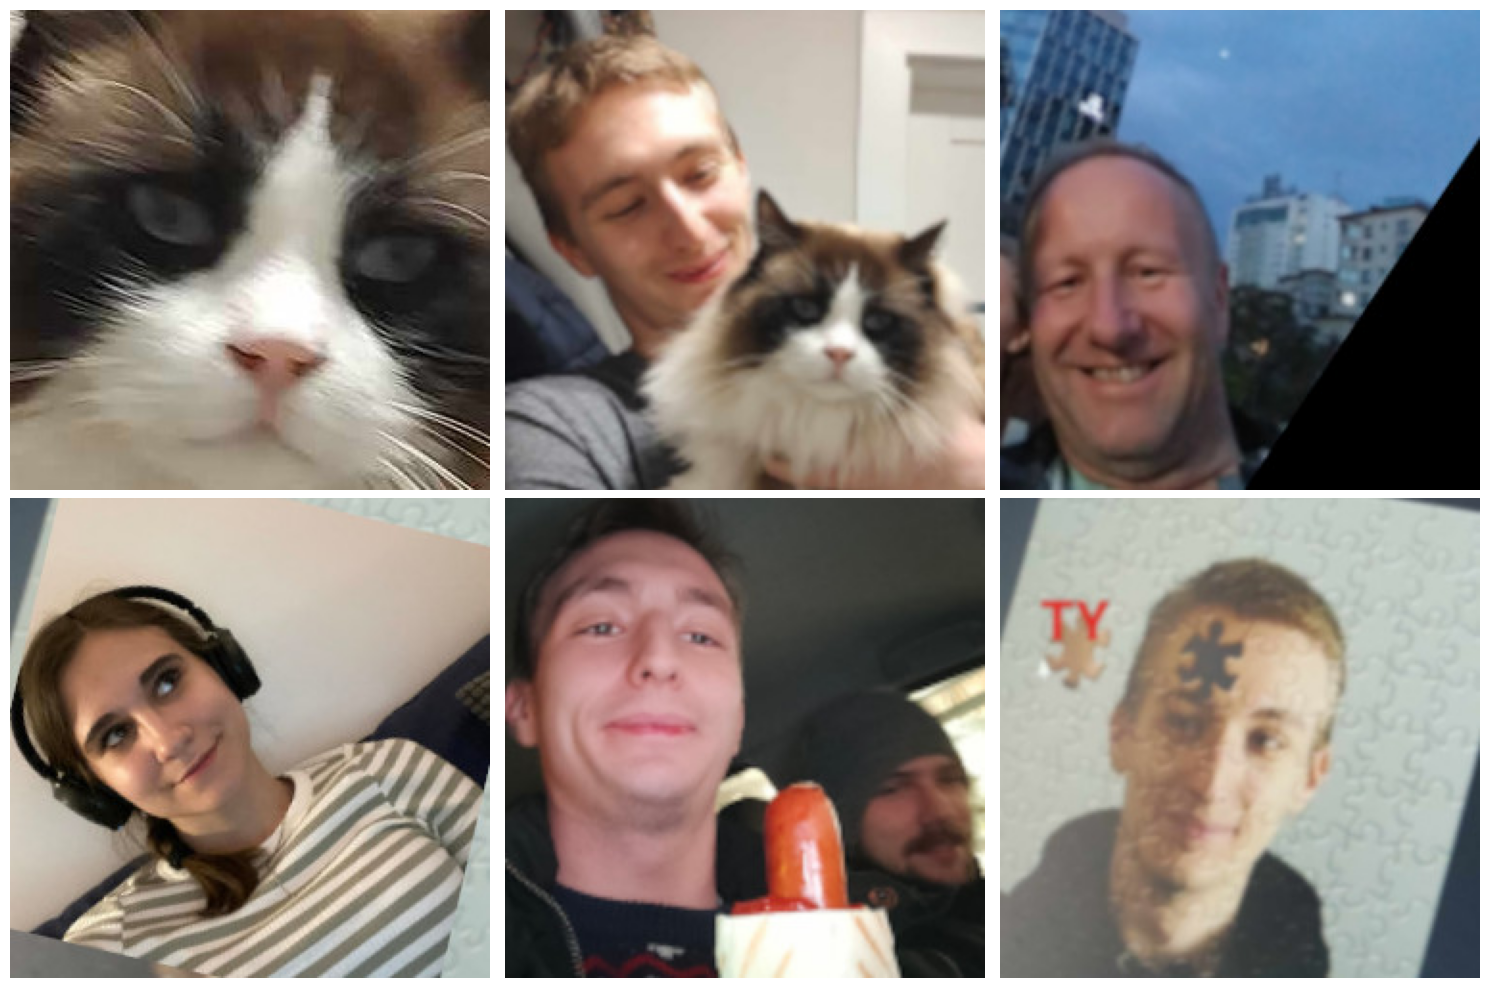

In [36]:
my_images = ['my_imgs/B.jpg', 'my_imgs/K.jpg', 'my_imgs/M.jpg',
             'my_imgs/N.jpg', 'my_imgs/P.jpg', 'my_imgs/T.jpg']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, image_name in enumerate(my_images):
    image = io.imread(image_name)

    ax = axes[idx]
    ax.imshow(image, cmap='gray')
    ax.axis('off')

    ROIs_xywh = get_ROIs(image)
    ROIs_coords = xywh_to_points(ROIs_xywh)
    ROIs = crop_ROIs(image, ROIs_coords)

    ROIs_components = faces_pca.transform(ROIs.reshape(ROIs.shape[0], 125 * 94))
    ROIs_projected = np.array(faces_pca.inverse_transform(ROIs_components).reshape(ROIs.shape[0], 125, 94))
    ROI_features_vectors = [extract_feature_vector(img) for img in ROIs_projected]

    preds = KNN.predict(ROI_features_vectors)

    boxes = []
    scores = []

    for i in range(len(preds)):
        acc = preds[i]
        if acc == 1:
            boxes.append(ROIs_coords[i])
            scores.append(acc)

    if len(boxes) != 0:
        NMS = image.non_max_suppression(boxes=boxes, scores=scores, max_output_size=len(boxes), iou_threshold=0.1)
        selected_bboxes = [boxes[idx] for idx in NMS]

        for x1, y1, x2, y2 in boxes:
            width = abs(x1 - x2)
            height = abs(y1 - y2)
            xmin = min([x1, x2])
            ymin = min([y1, y2])

            ax.add_patch(plt.Rectangle((xmin, ymin), width, height, edgecolor='red', lw=1, facecolor='none'))

plt.tight_layout()
plt.show()